In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

In [2]:
from PIL import Image

def read_calibration_data(filepath):
    calibration_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                try:
                    # Convert numerical values to floats
                    calibration_data[key] = float(value)
                except ValueError:
                    # Keep string values as-is
                    calibration_data[key] = value
    return calibration_data

def calculate_offsets(calibration_data):
    # Calculate pixels per meter
    ppm_x = calibration_data["optical-calibration.image-width"] / calibration_data["optical-calibration.region.width"]
    ppm_y = calibration_data["optical-calibration.image-height"] / calibration_data["optical-calibration.region.height"]
    
    # Calculate the global position in pixels
    global_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]*ppm_y #calibration_data["optical-calibration.region.x"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    global_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]*ppm_x #calibration_data["optical-calibration.region.y"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]
    
    # Calculate the offsets
    offset_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    offset_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    
    return ppm_x, ppm_y, global_x, global_y, offset_x, offset_y

def create_composite_image(image_paths, calibration_files, output_path):
    # Read calibration data from files
    calibration_datas = [read_calibration_data(file) for file in calibration_files]
    
    # Load images and rotate them by -90 degrees to align with the global coordinate system
    images = [Image.open(path).rotate(90, expand=True) for path in image_paths]
    
    # Calculate offsets and pixels per meter for each image
    calculations = [calculate_offsets(data) for data in calibration_datas]
    
    # Determine the canvas size
    canvas_width_meters = max([abs(c[2]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[2] is global_x
    canvas_height_meters = max([abs(c[3]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[3] is global_y
    
    # Assume the pixels per meter is the same for both images, as indicated by calibration data
    ppm_x, ppm_y = calculations[0][:2] 
    
    # Create the canvas
    canvas_width_pixels = int(round(canvas_width_meters))
    canvas_height_pixels = int(round(canvas_height_meters))
    canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))
    
    # Paste images onto the canvas
    for (ppm_x, ppm_y, global_x, global_y, offset_x, offset_y), image in zip(calculations, images):
        position_x = int(round((offset_x)))
        position_y = int(round((offset_y)))
        canvas.paste(image, (position_x, position_y))
    
    # Save the composite image
    canvas.save(output_path)
    print(f"Composite image saved to {output_path}")


In [3]:
import os
import glob

# Directory containing the 'tiling_x' folders
parent_directory = './tiling/'

# Glob pattern to match folders
folder_pattern = os.path.join(parent_directory, 'tiling-*')
folders = sorted(glob.glob(folder_pattern), key=lambda x: os.path.basename(x).split('-')[1:])

# Lists to hold the paths
image_paths = []
calibration_files = []
tiling_vars = {}

# Iterate through each folder
for folder in folders:
    # Extract folder name to dynamically create variable-like dictionary keys
    folder_name = os.path.basename(folder)
    tiling_vars[folder_name] = folder

    # Find all jpg images in the folder
    jpg_files = glob.glob(os.path.join(folder, 'snapshot-*.jpg'))
    image_paths.extend(jpg_files)

    # Find all calibration files in the folder
    cal_files = glob.glob(os.path.join(folder, 'optical-calibration-*.txt'))
    calibration_files.extend(cal_files)

    # Optionally open the first calibration file found in each folder
    if cal_files:
        first_cal_file = cal_files[0]
        print(f"Opening file: {first_cal_file}")
        # Here you can add your logic to open and process the file

# Output paths for demonstration purposes
output_path = './result.jpg'

# Print variables and paths for verification
print(f"Tiling folder variables: {tiling_vars}")
print(f"Image paths: {image_paths}")
print(f"Calibration files: {calibration_files}")
print(f"Output path: {output_path}")





Opening file: ./tiling/tiling-08.45.42.970/optical-calibration-2024.02.01-08.45.48-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.46.18.287/optical-calibration-2024.02.01-08.46.27-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.46.53.273/optical-calibration-2024.02.01-08.47.09-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.47.27.749/optical-calibration-2024.02.01-08.47.37-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.47.53.348/optical-calibration-2024.02.01-08.48.09-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.48.58.744/optical-calibration-2024.02.01-08.49.03-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.49.23.663/optical-calibration-2024.02.01-08.49.39-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.50.41.078/optical-calibration-2024.02.01-08.51.05-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-08.51.21.325/optical-calibration-2024.02.01-08.51.27-snapshot-000.jpk-opt-

In [4]:
calibrations = []
for file in calibration_files:
    calibration_data = read_calibration_data(file)
    calibrations.append(calibration_data)

calculations = []
for calibration in calibrations:
    calculation_data = calculate_offsets(calibration)
    calculations.append(calculation_data)

In [5]:
df = pd.DataFrame(calculations, columns = ['ppm_x', 'ppm_y', 'global_x', 'global_y', 'x in m', 'y in um'])

In [6]:
y_max = df.min()[3]
x_max = df.max()[2]
df['y_offset'] = -df['global_y']
df['x_offset'] = -(df['global_x']-x_max)

/tmp/ipykernel_42095/1944980004.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_max = df.min()[3]
/tmp/ipykernel_42095/1944980004.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_max = df.max()[2]


In [7]:
df

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset
0,406636.93792,406617.227854,1564.405954,-910.876431,0.003847,0.003847,910.876431,1012.508748
1,406636.93792,406617.227854,1562.034897,-443.190839,0.003842,0.003842,443.190839,1014.879804
2,406636.93792,406617.227854,2568.717621,-903.292706,0.006317,0.006317,903.292706,8.197080
3,406636.93792,406617.227854,2576.914701,-444.748211,0.006337,0.006337,444.748211,-0.000000
4,406636.93792,406617.227854,1561.560686,-1510.329239,0.003840,0.003840,1510.329239,1015.354015
5,406636.93792,406617.227854,1558.783163,-1444.107072,0.003834,0.003834,1444.107072,1018.131538
6,406636.93792,406617.227854,2566.414310,-1433.408603,0.006312,0.006312,1433.408603,10.500392
7,406636.93792,406617.227854,932.282367,-1444.174784,0.002293,0.002293,1444.174784,1644.632334
8,406636.93792,406617.227854,937.634180,-1630.179174,0.002306,0.002306,1630.179174,1639.280522
9,406636.93792,406617.227854,1593.671562,-925.637609,0.003919,0.003919,925.637609,983.243140


In [8]:
df

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset
0,406636.93792,406617.227854,1564.405954,-910.876431,0.003847,0.003847,910.876431,1012.508748
1,406636.93792,406617.227854,1562.034897,-443.190839,0.003842,0.003842,443.190839,1014.879804
2,406636.93792,406617.227854,2568.717621,-903.292706,0.006317,0.006317,903.292706,8.197080
3,406636.93792,406617.227854,2576.914701,-444.748211,0.006337,0.006337,444.748211,-0.000000
4,406636.93792,406617.227854,1561.560686,-1510.329239,0.003840,0.003840,1510.329239,1015.354015
5,406636.93792,406617.227854,1558.783163,-1444.107072,0.003834,0.003834,1444.107072,1018.131538
6,406636.93792,406617.227854,2566.414310,-1433.408603,0.006312,0.006312,1433.408603,10.500392
7,406636.93792,406617.227854,932.282367,-1444.174784,0.002293,0.002293,1444.174784,1644.632334
8,406636.93792,406617.227854,937.634180,-1630.179174,0.002306,0.002306,1630.179174,1639.280522
9,406636.93792,406617.227854,1593.671562,-925.637609,0.003919,0.003919,925.637609,983.243140


In [9]:
canvas_width_pixels = df['y_offset'].max()+1024 #c[2] is global_x
canvas_height_pixels = df['x_offset'].max()+1024 #c[3] is global_y

# Create the canvas
canvas_width_pixels = int(canvas_width_pixels)
canvas_height_pixels = int(canvas_height_pixels)
canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))


# List to hold the cropped images
cropped_images = []

# Loop through each image path
for path in image_paths:
    # Open and rotate the image (though here rotation is set to 0, so it's not actually changing the image)
    image = Image.open(path).rotate(0, expand=True)
    
    # Get the size of the image
    width, height = image.size
    
    # Define the cropping box. Remove the right 200 pixels
    crop_box = (0, 0, width - 100, height)
    
    # Crop the image
    cropped_img = image.crop(crop_box)
    # Add the cropped image to the list
    cropped_images.append(cropped_img)

df['image_path'] = cropped_images
df_new = df.iloc[8:]

df_new


,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset,image_path
8,406636.93792,406617.227854,937.634180,-1630.179174,0.002306,0.002306,1630.179174,1639.280522,<PIL.Image.Image image mode=L size=924x1024 at...
9,406636.93792,406617.227854,1593.671562,-925.637609,0.003919,0.003919,925.637609,983.243140,<PIL.Image.Image image mode=L size=924x1024 at...
10,406636.93792,406617.227854,2556.252640,-916.970495,0.006287,0.006287,916.970495,20.662061,<PIL.Image.Image image mode=L size=924x1024 at...
11,406636.93792,406617.227854,2561.807686,-520.856305,0.006300,0.006300,520.856305,15.107015,<PIL.Image.Image image mode=L size=924x1024 at...
12,406636.93792,406617.227854,1573.483712,-1534.366938,0.003870,0.003870,1534.366938,1003.430990,<PIL.Image.Image image mode=L size=924x1024 at...
13,406636.93792,406617.227854,2548.055560,-1521.637114,0.006266,0.006266,1521.637114,28.859141,<PIL.Image.Image image mode=L size=924x1024 at...
14,406636.93792,406617.227854,2560.385052,-1402.938281,0.006297,0.006297,1402.938281,16.529649,<PIL.Image.Image image mode=L size=924x1024 at...
15,406636.93792,406617.227854,1579.919436,-1396.844216,0.003886,0.003886,1396.844216,996.995266,<PIL.Image.Image image mode=L size=924x1024 at...
16,406636.93792,406617.227854,943.866670,-1395.015997,0.002321,0.002321,1395.015997,1633.048031,<PIL.Image.Image image mode=L size=924x1024 at...
17,406636.93792,406617.227854,999.078408,-1677.916012,0.002457,0.002457,1677.916012,1577.836293,<PIL.Image.Image image mode=L size=924x1024 at...


In [10]:
# Assuming `df` is your DataFrame and `cropped_images` is a list of image paths
# Step 1: Add the image paths to the DataFrame


# Step 2: Sort the DataFrame by 'y_offset' in descending order
df_sorted = df_new.sort_values(by='y_offset', ascending=False)

# Now you can loop through the sorted DataFrame
for i, row in df_sorted.iterrows():
    position_x = int(row['x_offset'])
    position_y = int(row['y_offset'])

    
    # Paste the image on the canvas at the specified position
    # Note: Adjust the order of position_x and position_y if necessary
    canvas.paste(row['image_path'], (position_y, position_x))

# Save the composite image
output_path = './result_new.jpg'
canvas.save(output_path)
print(f"Composite image saved to {output_path}")


Composite image saved to ./result_new.jpg


In [11]:
# Step 2: Sort the DataFrame by 'y_offset' in descending order
df_sorted = df_new.sort_values(by='y_offset', ascending=False)
df_sorted = df_sorted.sort_values(by='x_offset', ascending=True)
df_sorted.loc[df_sorted['x_offset'] > 100, 'x_offset'] -= 100

In [12]:
df_sorted

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset,image_path
11,406636.93792,406617.227854,2561.807686,-520.856305,0.006300,0.006300,520.856305,15.107015,<PIL.Image.Image image mode=L size=924x1024 at...
14,406636.93792,406617.227854,2560.385052,-1402.938281,0.006297,0.006297,1402.938281,16.529649,<PIL.Image.Image image mode=L size=924x1024 at...
10,406636.93792,406617.227854,2556.252640,-916.970495,0.006287,0.006287,916.970495,20.662061,<PIL.Image.Image image mode=L size=924x1024 at...
13,406636.93792,406617.227854,2548.055560,-1521.637114,0.006266,0.006266,1521.637114,28.859141,<PIL.Image.Image image mode=L size=924x1024 at...
9,406636.93792,406617.227854,1593.671562,-925.637609,0.003919,0.003919,925.637609,883.243140,<PIL.Image.Image image mode=L size=924x1024 at...
15,406636.93792,406617.227854,1579.919436,-1396.844216,0.003886,0.003886,1396.844216,896.995266,<PIL.Image.Image image mode=L size=924x1024 at...
12,406636.93792,406617.227854,1573.483712,-1534.366938,0.003870,0.003870,1534.366938,903.430990,<PIL.Image.Image image mode=L size=924x1024 at...
17,406636.93792,406617.227854,999.078408,-1677.916012,0.002457,0.002457,1677.916012,1477.836293,<PIL.Image.Image image mode=L size=924x1024 at...
16,406636.93792,406617.227854,943.866670,-1395.015997,0.002321,0.002321,1395.015997,1533.048031,<PIL.Image.Image image mode=L size=924x1024 at...
8,406636.93792,406617.227854,937.634180,-1630.179174,0.002306,0.002306,1630.179174,1539.280522,<PIL.Image.Image image mode=L size=924x1024 at...


In [13]:
# Assuming `df` is your DataFrame and `cropped_images` is a list of image paths
# Step 1: Add the image paths to the DataFrame
df_sorted = df_sorted.sort_values(by='y_offset', ascending=False)

# Now you can loop through the sorted DataFrame
for i, row in df_sorted.iterrows():
    position_x = int(row['x_offset'])
    position_y = int(row['y_offset'])

    
    # Paste the image on the canvas at the specified position
    # Note: Adjust the order of position_x and position_y if necessary
    canvas.paste(row['image_path'], (position_y, position_x))

# Save the composite image
output_path = './result_new.jpg'
canvas.save(output_path)
print(f"Composite image saved to {output_path}")


Composite image saved to ./result_new.jpg


In [14]:
afm = pd.read_csv("./ZWV16_processed_forcecurves.tsv", sep = "\t")
afm['X Position'] = (((afm['X Position'])*df['ppm_x'][0])*(-1))+x_max+440
afm['Y Position'] = (((afm['Y Position'])*df['ppm_x'][1])*(-1))+500

In [15]:
afm.to_csv("./ZWV16_new/afm.csv", sep = ",")

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


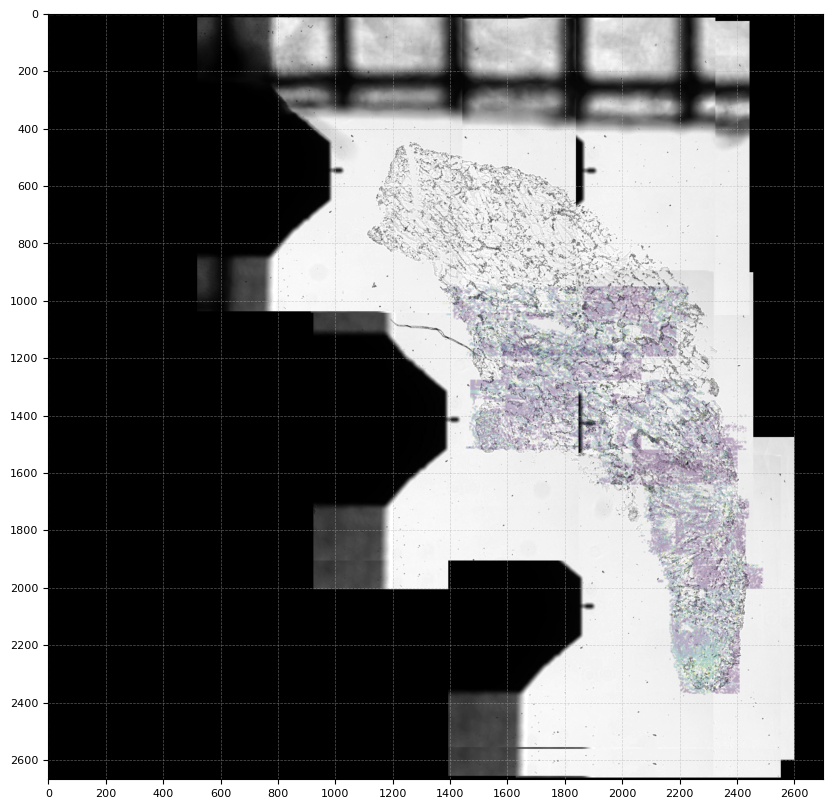

In [16]:
# Filter the data to exclude outliers
filtered_afm = afm[afm["Young's Modulus [Pa]"] < 10000]

afm_slide = cv2.imread('./result_new.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.1, alpha=0.2)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.savefig('Location_all.png', bbox_inches='tight')

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")

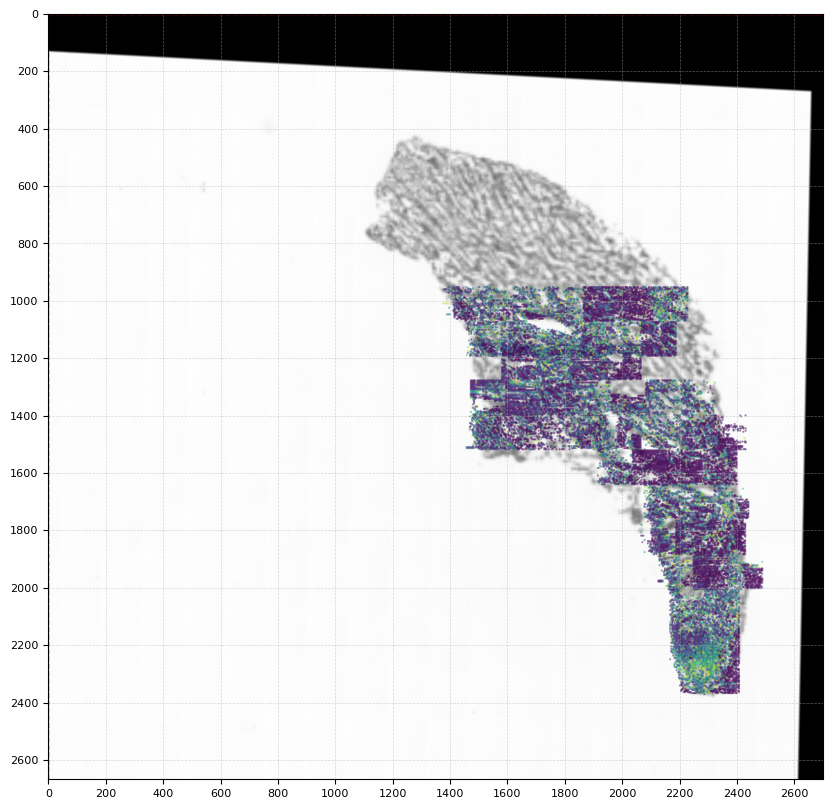

In [17]:
afm_slide = cv2.imread('./ZWV16_new/transformed_image-new2.tif', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.3, alpha= 0.5)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")